In [1]:
import sys, os
os.chdir("..")
sys.path.append("classifier")

In [2]:
from dataloader import AslDataset, AslTestDataset, preprocess_image
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
import glob
from PIL import Image

train_data = AslDataset("data/asl_alphabet_train/asl_alphabet_train")
train_loader = DataLoader(train_data, sampler=RandomSampler(train_data))

test_data = AslTestDataset("data/asl_alphabet_test/asl_alphabet_test", train_data.classes)
test_loader = DataLoader(test_data)

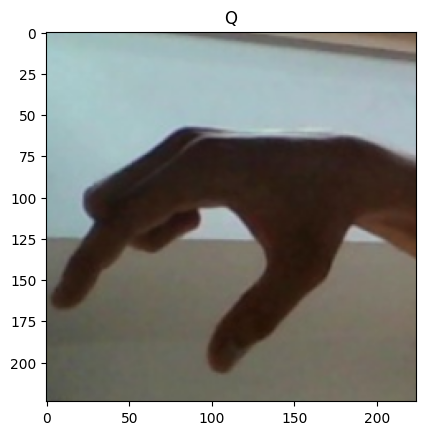

In [4]:
from matplotlib import pyplot as plt

for item in test_loader:
    label = item["label"][0]
    image = item["image"][0]

    plt.title(train_data.classes[label])
    plt.imshow(image.movedim(0, 2))
    plt.show()
    break

In [34]:
import torch
import torch.nn.functional as F

learning_rate = 0.001
epsilon = 1e-07
epochs = 2

mobile_net = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
mobile_net.to("cuda")
mobile_net.eval()

model = torch.nn.Sequential(
    torch.nn.Linear(1000, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 29),
).to("cuda")

opt = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=epsilon)

for _ in range(epochs):
    for i, item in enumerate(train_loader):
        model.train()
        label = item["label"]
        image = item["image"].to("cuda")

        expected = F.one_hot(label, len(train_data.classes)).to(torch.float).to("cuda")

        interme = mobile_net(image)
        output = model(interme)
        
        loss = F.cross_entropy(output, expected)
        loss.backward()
        opt.step()
        opt.zero_grad()

        if i % 100 == 0:
            model.eval()

            acc = 0
            loss = 0
            for item in test_loader:
                label = item["label"]
                image = item["image"].to("cuda")
        
                expected = F.one_hot(label, len(train_data.classes)).to(torch.float).to("cuda")
        
                interme = mobile_net(image)
                output = model(interme)
        
                pred = F.softmax(output, dim=-1).argmax().to("cpu")
                loss += F.cross_entropy(output, expected)
                acc += 1 if pred == label else 0

            n = len(test_loader)
            print(f"Loss: {loss/n:.04f}  Acc: {acc/n*100:.02f}%")

Using cache found in /home/aolse/.cache/torch/hub/pytorch_vision_v0.10.0


Loss: 3.4735  Acc: 3.57%
Loss: 3.3337  Acc: 3.57%
Loss: 3.3355  Acc: 7.14%
Loss: 3.2513  Acc: 3.57%
Loss: 3.1704  Acc: 7.14%
Loss: 2.9662  Acc: 14.29%
Loss: 2.6221  Acc: 21.43%
Loss: 2.5733  Acc: 17.86%
Loss: 2.5333  Acc: 39.29%
Loss: 2.3815  Acc: 35.71%
Loss: 2.1573  Acc: 21.43%
Loss: 2.4411  Acc: 25.00%
Loss: 1.7606  Acc: 42.86%
Loss: 1.7051  Acc: 42.86%
Loss: 1.4345  Acc: 53.57%
Loss: 1.4930  Acc: 50.00%
Loss: 1.3828  Acc: 46.43%
Loss: 1.4168  Acc: 42.86%
Loss: 1.4571  Acc: 39.29%
Loss: 1.2854  Acc: 42.86%
Loss: 1.3192  Acc: 42.86%
Loss: 1.2200  Acc: 46.43%
Loss: 1.1886  Acc: 60.71%
Loss: 1.2768  Acc: 42.86%
Loss: 1.3338  Acc: 46.43%
Loss: 1.1624  Acc: 42.86%
Loss: 1.0888  Acc: 57.14%
Loss: 1.0560  Acc: 64.29%
Loss: 1.1109  Acc: 57.14%
Loss: 0.9972  Acc: 50.00%
Loss: 0.9953  Acc: 64.29%
Loss: 1.0688  Acc: 53.57%
Loss: 0.8356  Acc: 67.86%
Loss: 1.0776  Acc: 64.29%
Loss: 1.2081  Acc: 53.57%
Loss: 1.0092  Acc: 57.14%
Loss: 1.1224  Acc: 57.14%
Loss: 0.8622  Acc: 64.29%
Loss: 0.6752  Acc

KeyboardInterrupt: 

In [35]:
print(model)

Sequential(
  (0): Linear(in_features=1000, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=29, bias=True)
)


In [39]:
import pickle

with open("model.pkz", "wb") as file:
    pickle.dump((mobile_net, model, train_data.classes), file)